<a href="https://colab.research.google.com/github/sanyamss99/Self_driving_car/blob/main/train__keras_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
images_path = "/content/drive/My Drive/images/"
data_path = "/content/drive/My Drive/car_data.txt"

In [ ]:
X=[]
Y=[]
lines=[]

with open(data_path) as file:
    lines=file.readlines()

for line in lines:
    w=line.split()
    X.append(w[0])
    Y.append(float(w[1]))

In [ ]:
import os
cnt=0
for i,x in enumerate(X):
    X[i]=images_path+X[i]
    if os.path.isfile(X[i]):
        cnt+=1
    else:
        print(x[i])
    
print(cnt)

45406


In [ ]:
import math

for i,y in enumerate(Y):
    Y[i]=(y*math.pi)/180
    
print(Y[89])

0.024609142453120045


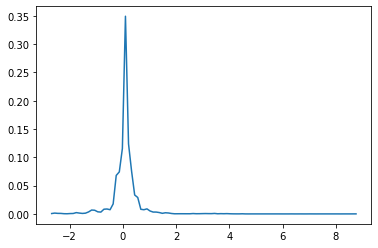

In [ ]:
import matplotlib.pyplot as plt

counts,bin_edges=np.histogram(Y,bins=100,density=True)
pdf=counts/sum(counts)
plt.plot(bin_edges[1:],pdf)
plt.show()

In [ ]:

import keras
import cv2

class Generator(keras.utils.Sequence):
    
    def __init__(self,X,Y,batch_size):
        self.X=X
        self.Y=Y
        self.batch_size=batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.X)/batch_size))
    
    def __getitem__(self,idx):
        #print(idx)
        batch_x=self.X[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_y=self.Y[idx*self.batch_size : (idx+1)*self.batch_size]
        
        x_vec=[]
        for img in batch_x:
            x_vec.append(cv2.resize(cv2.imread(img)[-150:],(200,66))/255.0)
            
        return np.array(x_vec),np.array(batch_y)

In [ ]:

from keras.models import Sequential
from keras.layers import Dense,Flatten,BatchNormalization,Dropout
from keras.layers.convolutional import Conv2D,MaxPooling2D

width=200
height=66
channels=3
batch_size=100
epochs=30
model=Sequential()

import tensorflow.compat.v1 as tf

def conv2d(filters,kernel_size,strides,f=0):
  #For 1st layer to add input shape
  if f==1:
    return Conv2D(filters,kernel_size=kernel_size,strides=strides,input_shape=(width,height,channels),
                data_format='channels_last',activation='relu',
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                use_bias=True, bias_initializer=tf.keras.initializers.Constant(value=0.1))

  #For rest of the layers
  else:
    return Conv2D(filters,kernel_size=kernel_size,strides=strides,activation='relu',
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                use_bias=True, bias_initializer=tf.keras.initializers.Constant(value=0.1))
      

def dense(units):
  return Dense(units, activation='relu',
              kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
              use_bias=True, bias_initializer=tf.keras.initializers.Constant(value=0.1))


def modifiedTanh(x):
   return tf.multiply(tf.atan(x), 2) 

tf.keras.utils.get_custom_objects().update({'modifiedTanh': modifiedTanh})

In [ ]:
#Conv Layer-1
model.add(conv2d(24,5,2,1))
# model.add(BatchNormalization())

#Conv Layer-2
model.add(conv2d(36,5,2))
# model.add(BatchNormalization())

#Conv Layer-3
model.add(conv2d(48,5,2))
# model.add(BatchNormalization())

#Conv Layer-4
model.add(conv2d(64,3,1))
# model.add(BatchNormalization())

#Conv Layer-5
model.add(conv2d(64,3,1))
# model.add(BatchNormalization())

#Flattening
model.add(Flatten())

#Fully Connected Layer-1
model.add(dense(1164))
model.add(Dropout(0.2))

#Fully Connected Layer-2
model.add(dense(100))
model.add(Dropout(0.2))

#Fully Connected Layer-3
model.add(dense(50))
model.add(Dropout(0.2))

#Fully Connected Layer-4
model.add(dense(10))
model.add(Dropout(0.2))

# The Output Layer :
model.add(Dense(1))

In [ ]:

# Compile the network :


def loss(yTrue,yPred):
  L2NormConst = 0.001
  train_vars = model.trainable_variables

  loss=tf.reduce_mean(tf.square(tf.subtract(yTrue, yPred)));
  if len(train_vars)!=0:
    loss+=tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst

  return loss

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=loss, optimizer=optimizer, metrics=[loss,'mean_squared_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 31, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 14, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 5, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 3, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 1, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 1164)              1

In [ ]:
#split=int(.8*len(X))
#X_train=X[0:split]
#X_val=X[split:]
#Y_train=Y[0:split]
#Y_val=Y[split:]

from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(X, Y, test_size=0.25, random_state=10)

print("train:",len(X_train),len(Y_train))
print("val:",len(X_val),len(Y_val))

train: 34054 34054
val: 11352 11352


In [ ]:
from sklearn.metrics import mean_squared_error

z=[0]*len(Y_val)
mean_squared_error(Y_val, z)

0.2898044832855096

In [ ]:

training_batch_generator =Generator(X_train, Y_train, batch_size)
validation_batch_generator =Generator(X_val, Y_val, batch_size)

model.fit(training_batch_generator,
            steps_per_epoch=int(len(X_train)//batch_size),
            epochs = epochs,
            verbose=1,
            workers=8,
            validation_data=validation_batch_generator,
            validation_steps=int(len(X_val)//batch_size))

Epoch 1/30
340/340 [==============================] - 2730s 8s/step - loss: 6.1447 - mean_squared_error: 0.5603 - val_loss: 5.3683 - val_mean_squared_error: 0.2901
Epoch 2/30
340/340 [==============================] - 153s 450ms/step - loss: 4.9756 - mean_squared_error: 0.2953 - val_loss: 4.6178 - val_mean_squared_error: 0.2895
Epoch 3/30
340/340 [==============================] - 154s 453ms/step - loss: 4.3365 - mean_squared_error: 0.2933 - val_loss: 4.0735 - val_mean_squared_error: 0.2852
Epoch 4/30
340/340 [==============================] - 152s 446ms/step - loss: 3.8668 - mean_squared_error: 0.2886 - val_loss: 3.6658 - val_mean_squared_error: 0.2771
Epoch 5/30
340/340 [==============================] - 154s 452ms/step - loss: 3.5072 - mean_squared_error: 0.2788 - val_loss: 3.3449 - val_mean_squared_error: 0.2630
Epoch 6/30
340/340 [==============================] - 152s 448ms/step - loss: 3.2189 - mean_squared_error: 0.2654 - val_loss: 3.0771 - val_mean_squared_error: 0.2434
Epoch 

In [ ]:
model.save('m1.h5')

In [ ]:
print(tf.__version__)

2.3.0
